<a href="https://colab.research.google.com/github/mr-rojit/movies-reviews-sentiment-analysis/blob/main/final_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [139]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import string
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from gensim.models import word2vec

### Exploratory Data Analysis

In [140]:
df = pd.read_csv('movies_reviews_final.csv')
df.head(10)

,user,date_review,stars,title_review,review
0,MovieWarfare,17 February 2024,1/10,Makes Morbius look like The Dark Knight\n,I would absolutely love to be in these Sony me...
1,syntory,15 February 2024,2/10,How are bad writers able to continually get h...,Look at the profiles for the writers that wrot...
2,AlsExGal,17 February 2024,2/10,"I had a bad feeling about this one, going in....",... when I saw Dakota Johnson was starring in ...
3,Orlando_Gardner,19 July 2023,9/10,Murphy is exceptional\n,You'll have to have your wits about you and yo...
4,AfricanBro,26 February 2024,9/10,Long live the fighters\n,Phenomenal stuff. I'll probably calm down tomo...
5,her5066,26 February 2024,10/10,This is what Hollywood needs!\n,This is what Hollywood needs. A great story wi...
6,and_mikkelsen,28 February 2024,10/10,Ladies and gentleman.. the PEAK of filmmaking...,This is the kind of movie that is impossible t...
7,parksiet,31 December 2023,4/10,Not for me\n,Poor Things simply just wasn't for me. I reall...
8,Pjtaylor-96-138044,23 January 2024,5/10,Turns out the real poor things were the audie...,Poor Things (2023) is an ostensibly feminist f...
9,ThereelscoopwithKK,12 March 2024,1/10,Pompous and Grotesque\n,A movie that's decorated as something special ...


In [141]:
df.shape

(5058, 5)

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5058 entries, 0 to 5057
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user          5058 non-null   object
 1   date_review   5058 non-null   object
 2   stars         5058 non-null   object
 3   title_review  5058 non-null   object
 4   review        5058 non-null   object
dtypes: object(5)
memory usage: 197.7+ KB


### Transforming stars column(extracting star provied by user)

In [143]:
def extract_stars(data):
    star = int(data.split('/')[0])
    return 0 if star<=5 else 1


In [144]:
df['sentiment'] = df['stars'].apply(extract_stars)

In [145]:
df.head()

,user,date_review,stars,title_review,review,sentiment
0,MovieWarfare,17 February 2024,1/10,Makes Morbius look like The Dark Knight\n,I would absolutely love to be in these Sony me...,0
1,syntory,15 February 2024,2/10,How are bad writers able to continually get h...,Look at the profiles for the writers that wrot...,0
2,AlsExGal,17 February 2024,2/10,"I had a bad feeling about this one, going in....",... when I saw Dakota Johnson was starring in ...,0
3,Orlando_Gardner,19 July 2023,9/10,Murphy is exceptional\n,You'll have to have your wits about you and yo...,1
4,AfricanBro,26 February 2024,9/10,Long live the fighters\n,Phenomenal stuff. I'll probably calm down tomo...,1


In [146]:
fig = px.histogram(df,
             x='stars',
             height=500,
             title='stars distribution',
             color='stars'
            )
fig.show()

In [147]:
df = df[['review', 'sentiment']]

## Data Preprocessing

In [148]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [149]:
stop_words = set(stopwords.words('english'))
def process_text(text:str):
    # Remove "\n" characters as our text has at the very end
    text = text.replace("\n", "")

    text = re.sub(r'\d+', '', text)

    # removing shite spaces in both ends if exists
    text = text.strip()

    # Tokenize the text
    tokens = word_tokenize(text)

    table = str.maketrans('', '', string.punctuation)
    tokens = [word.lower() for word in tokens if word.lower() not in stop_words]
    tokens = [word.translate(table) for word in tokens]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join the filtered tokens back into a sentence
    filtered_text = ' '.join(tokens)

    return filtered_text

In [150]:
df['review'] = df['review'].apply(process_text)

<Axes: xlabel='sentiment', ylabel='count'>

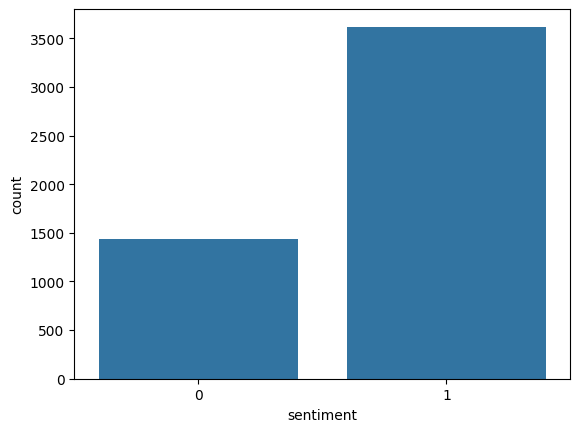

In [151]:
sns.countplot(df, x='sentiment')

In [152]:
from wordcloud import WordCloud

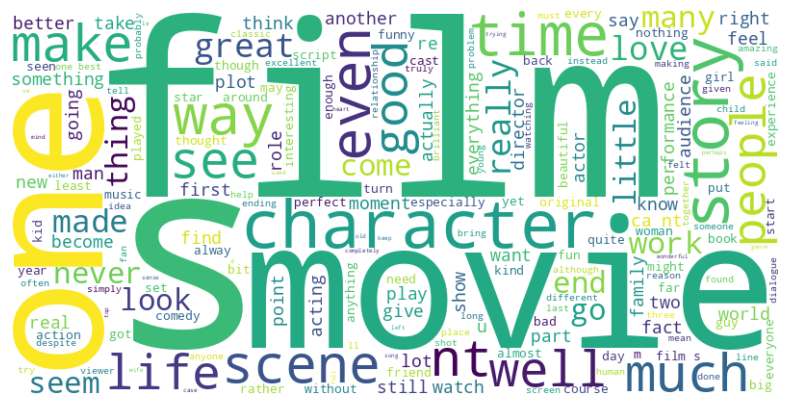

In [153]:
text_data = ' '.join(df['review'])

words = text_data.split()

word_counts = pd.Series(words).value_counts()
top_n_words = 30
top_words = word_counts.head(top_n_words)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [154]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, auc, roc_curve, roc_auc_score

In [155]:
X =  df['review']
y = df['sentiment']

Converting text to vector using TF-IDF

In [156]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X)

In [157]:
## Using Smote for handling class imbalnace

In [158]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

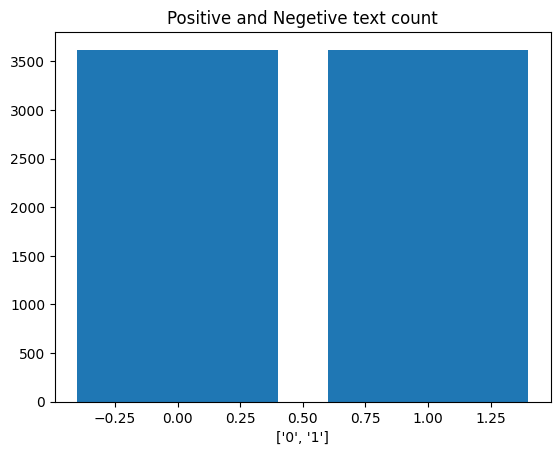

In [159]:
plt.bar(y_resampled.value_counts().keys(), y_resampled.value_counts())
plt.title('Positive and Negetive text count')
plt.xlabel(['0', '1'])
plt.show()

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [161]:
class Score:

  def get_accuracy(self, test, pred):
    return accuracy_score(test, pred).round(3)

  def get_precision(self, test, pred):
    return precision_score(test, pred).round(3)

  def get_recall(self, test, pred):
    return recall_score(test, pred).round(3)

  def get_f1_score(self, test, pred):
    return f1_score(test, pred).round(3)

  def get_all(self, name, test, pred):
    a, p, r, f = self.get_accuracy(test, pred), self.get_precision(test, pred), self.get_recall(test, pred), self.get_f1_score(test, pred)
    return pd.DataFrame(np.array([[name, a, p, r, f]]),columns=['Algorithm_name', 'accuracy', 'precision', 'recall', 'f1_score'])
    # return a,p,r,f


In [162]:
# comparision_df = pd.DataFrame({}, columns=['Algorithm_name', 'accuracy', 'precision', 'recall', 'f1_score'])
# comparision_df

In [163]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)
logistic_regression.score(X_train, y_train)

0.9773086029992107

### Training result from logistic regression

In [164]:
logistic_train_pred = logistic_regression.predict(X_train)
print(classification_report(y_train, logistic_train_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2558
           1       0.97      0.98      0.98      2510

    accuracy                           0.98      5068
   macro avg       0.98      0.98      0.98      5068
weighted avg       0.98      0.98      0.98      5068



In [165]:
# test set evaluation
logistic_y_pred = logistic_regression.predict(X_test)
logistic_accuracy = accuracy_score(y_test, logistic_y_pred)
logistic_accuracy

0.9383057090239411

In [166]:
print(classification_report(y_test, logistic_y_pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1062
           1       0.94      0.94      0.94      1110

    accuracy                           0.94      2172
   macro avg       0.94      0.94      0.94      2172
weighted avg       0.94      0.94      0.94      2172



Confusion matrix for logidtic regression (test set)

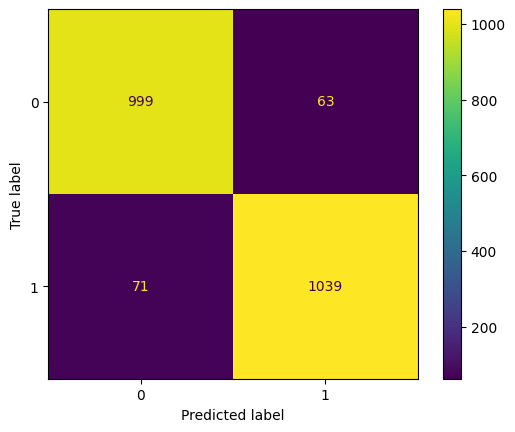

In [167]:
conf_matrix = confusion_matrix(y_test, logistic_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=logistic_regression.classes_)
disp.plot()

In [168]:
y_pred_proba = logistic_regression.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

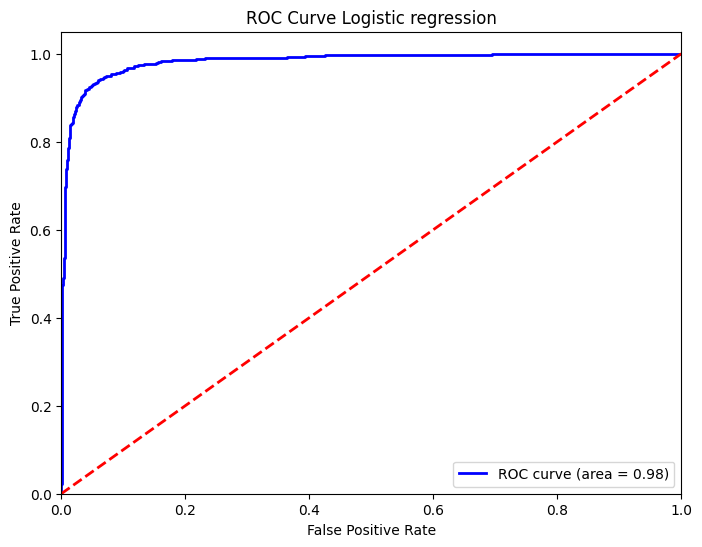

In [169]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Logistic regression')
plt.legend(loc='lower right')
plt.show()

Applying PCA for dimentionality reduction

In [170]:
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train.toarray())
X_test_pca = pca.fit_transform(X_test.toarray())

In [171]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_pca, y_train)

logistic_regression.score(X_train_pca, y_train)

0.85655090765588

In [172]:
logistic_y_pred = logistic_regression.predict(X_test_pca)
logistic_accuracy = accuracy_score(y_test, logistic_y_pred)
logistic_accuracy

0.7794659300184162

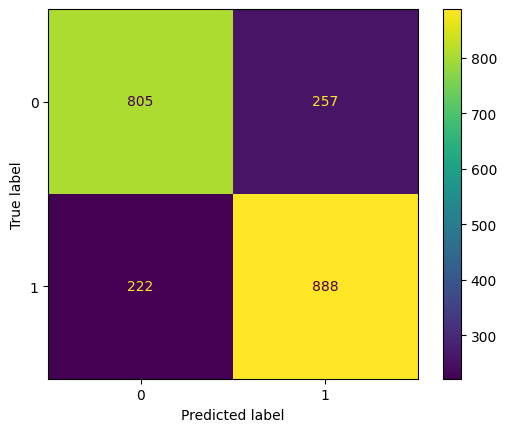

In [173]:
conf_matrix = confusion_matrix(y_test, logistic_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=logistic_regression.classes_)
disp.plot()

In [174]:
comparision_df = Score().get_all('Logistic Regression', y_test, logistic_y_pred)
comparision_df

,Algorithm_name,accuracy,precision,recall,f1_score
0,Logistic Regression,0.779,0.776,0.8,0.788


In [175]:
y_pred_proba = logistic_regression.predict_proba(X_test_pca)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

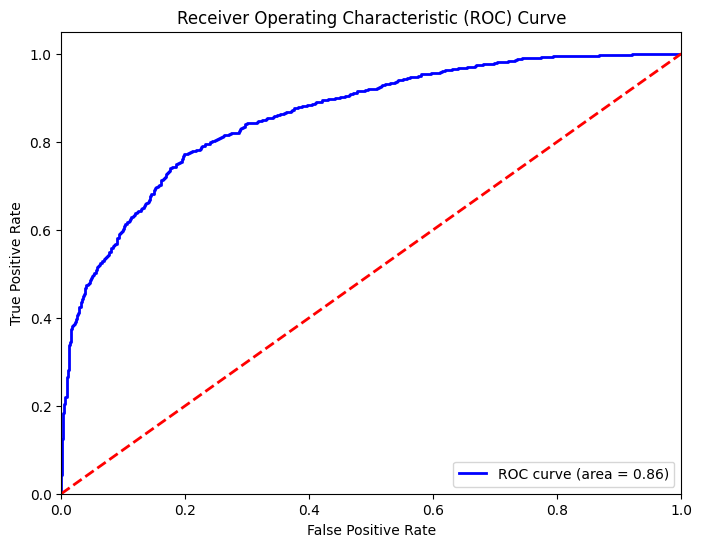

In [176]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Random Forest Classifier after PCA

In [177]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_pca, y_train)
rf_classifier.score(X_train_pca, y_train)

1.0

In [178]:
y_pred = rf_classifier.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
print(classification_report(y_test, y_pred))

0.7647329650092081
              precision    recall  f1-score   support

           0       0.74      0.81      0.77      1062
           1       0.80      0.72      0.76      1110

    accuracy                           0.76      2172
   macro avg       0.77      0.77      0.76      2172
weighted avg       0.77      0.76      0.76      2172



RFC with hyperparameter tuning

In [179]:
param_grid = {
    'n_estimators': [50, 100, 250],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_features': ['sqrt', 'log2']
}

rf_classifier = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_grid, n_iter=100, cv=5, random_state=42)
random_search.fit(X_train_pca, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100,
                   param_distributions={'max_depth': [None, 5, 10],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4, 10],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'n_estimators': [50, 100, 250]},
                   random_state=42)

In [180]:
best_params = random_search.best_params_
best_params

{'n_estimators': 250,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None}

In [181]:
best_rf_model = random_search.best_estimator_
best_rf_model

RandomForestClassifier(min_samples_split=5, n_estimators=250, random_state=42)

In [182]:
y_pred = best_rf_model.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7711786372007366

In [183]:
comparision_df = pd.concat([comparision_df, Score().get_all('Random Forest', y_test, y_pred)])
comparision_df

,Algorithm_name,accuracy,precision,recall,f1_score
0,Logistic Regression,0.779,0.776,0.8,0.788
0,Random Forest,0.771,0.8,0.737,0.767


Using ANN

In [184]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from tensorflow.keras import regularizers

In [185]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_test_pca.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.fit(X_train_pca, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
127/127 [==============================] - 2s 6ms/step - loss: 0.5136 - accuracy: 0.8177 - val_loss: 0.3512 - val_accuracy: 0.8629
Epoch 2/50
127/127 [==============================] - 0s 4ms/step - loss: 0.3331 - accuracy: 0.8572 - val_loss: 0.3278 - val_accuracy: 0.8600
Epoch 3/50
127/127 [==============================] - 0s 4ms/step - loss: 0.3271 - accuracy: 0.8569 - val_loss: 0.3268 - val_accuracy: 0.8619
Epoch 4/50
127/127 [==============================] - 0s 4ms/step - loss: 0.3248 - accuracy: 0.8619 - val_loss: 0.3276 - val_accuracy: 0.8639
Epoch 5/50
127/127 [==============================] - 1s 7ms/step - loss: 0.3198 - accuracy: 0.8582 - val_loss: 0.3365 - val_accuracy: 0.8619
Epoch 6/50
127/127 [==============================] - 1s 6ms/step - loss: 0.3186 - accuracy: 0.8624 - val_loss: 0.3201 - val_accuracy: 0.8679
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: 0.3130 - accuracy: 0.8673 - val_loss: 0.3200 - val_accuracy: 0.8669
Epoch 

In [186]:
ann_pred = model.predict(X_test_pca)
ann_pred = (ann_pred > 0.5).astype(int)

68/68 [==============================] - 0s 1ms/step


In [187]:
accuracy = accuracy_score(y_test, ann_pred)
print("Accuracy on test set before dropout and regularization:", accuracy)

Accuracy on test set before dropout and regularization: 0.7914364640883977


In [188]:
print(classification_report(y_test, ann_pred))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1062
           1       0.80      0.78      0.79      1110

    accuracy                           0.79      2172
   macro avg       0.79      0.79      0.79      2172
weighted avg       0.79      0.79      0.79      2172



In [189]:
comparision_df = pd.concat([comparision_df, Score().get_all('Neural Network', y_test, ann_pred)])
comparision_df

,Algorithm_name,accuracy,precision,recall,f1_score
0,Logistic Regression,0.779,0.776,0.8,0.788
0,Random Forest,0.771,0.8,0.737,0.767
0,Neural Network,0.791,0.804,0.782,0.793


ANN with dropout and Regularization

In [190]:
model = Sequential([
    Dense(32, input_shape=(X_train_pca.shape[1],), activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [191]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 32)                352       
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_42 (Dense)            (None, 64)                2112      
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_43 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2529 (9.88 KB)
Trainable params: 2529 (9.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [192]:
# Train the model
history = model.fit(X_train_pca, y_train, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
127/127 [==============================] - 2s 7ms/step - loss: 0.6561 - accuracy: 0.6860 - val_loss: 0.5650 - val_accuracy: 0.8087
Epoch 2/30
127/127 [==============================] - 1s 4ms/step - loss: 0.4805 - accuracy: 0.8014 - val_loss: 0.3770 - val_accuracy: 0.8649
Epoch 3/30
127/127 [==============================] - 1s 5ms/step - loss: 0.3894 - accuracy: 0.8337 - val_loss: 0.3440 - val_accuracy: 0.8609
Epoch 4/30
127/127 [==============================] - 0s 4ms/step - loss: 0.3661 - accuracy: 0.8456 - val_loss: 0.3336 - val_accuracy: 0.8639
Epoch 5/30
127/127 [==============================] - 1s 4ms/step - loss: 0.3554 - accuracy: 0.8505 - val_loss: 0.3324 - val_accuracy: 0.8639
Epoch 6/30
127/127 [==============================] - 1s 4ms/step - loss: 0.3530 - accuracy: 0.8498 - val_loss: 0.3293 - val_accuracy: 0.8649
Epoch 7/30
127/127 [==============================] - 1s 4ms/step - loss: 0.3502 - accuracy: 0.8559 - val_loss: 0.3313 - val_accuracy: 0.8619
Epoch 

In [193]:
ann_pred = model.predict(X_test_pca)
ann_pred = (ann_pred > 0.5).astype(int)
accuracy = accuracy_score(y_test, ann_pred)
print("Accuracy on test set after dropout and regularization:", accuracy)

68/68 [==============================] - 0s 2ms/step
Accuracy on test set after dropout and regularization: 0.8057090239410681


In [194]:
comparision_df = pd.concat([comparision_df, Score().get_all('Neural Network with Dropout', y_test, ann_pred)])
comparision_df

,Algorithm_name,accuracy,precision,recall,f1_score
0,Logistic Regression,0.779,0.776,0.8,0.788
0,Random Forest,0.771,0.8,0.737,0.767
0,Neural Network,0.791,0.804,0.782,0.793
0,Neural Network with Dropout,0.806,0.822,0.791,0.806


In [195]:
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

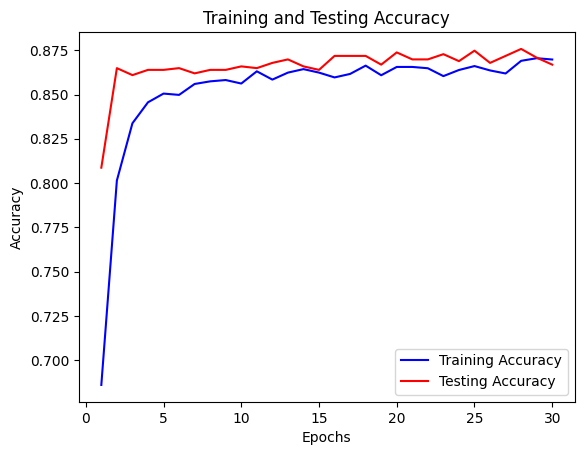

In [196]:
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, test_accuracy, 'r', label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [197]:
_, accuracy = model.evaluate(X_test_pca, y_test)
print("Test Accuracy:", accuracy)

68/68 [==============================] - 0s 2ms/step - loss: 0.4484 - accuracy: 0.8057
Test Accuracy: 0.8057090044021606


In [198]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

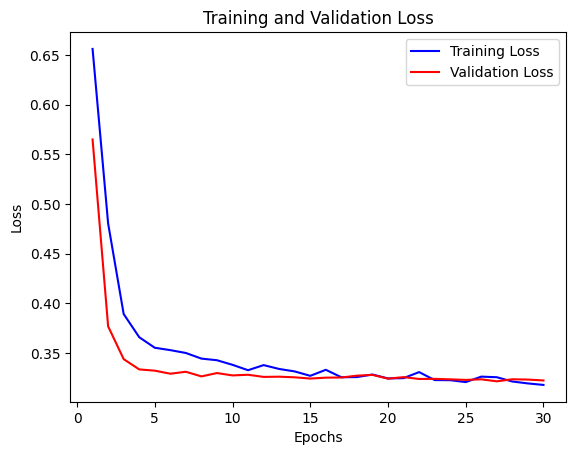

In [199]:
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [200]:
# Confusion matrix for ANN prediction

In [201]:
y_pred_proba = model.predict(X_test_pca)
y_pred = np.argmax(y_pred_proba, axis=1)

68/68 [==============================] - 0s 2ms/step


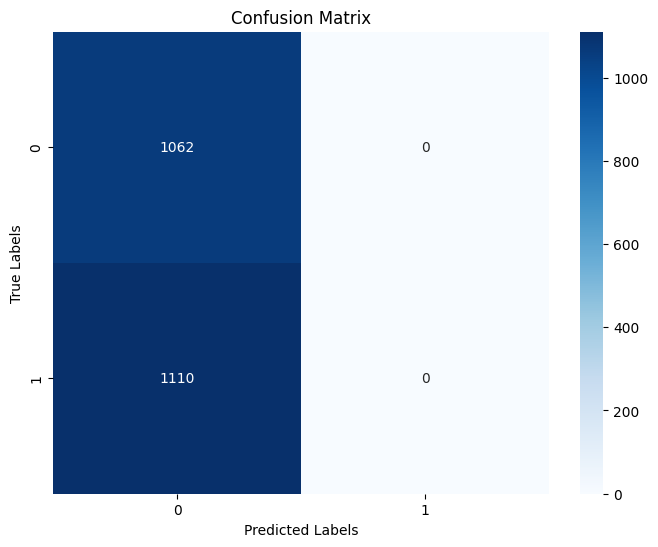

In [202]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [203]:
# Roc AUC for ANN

In [204]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

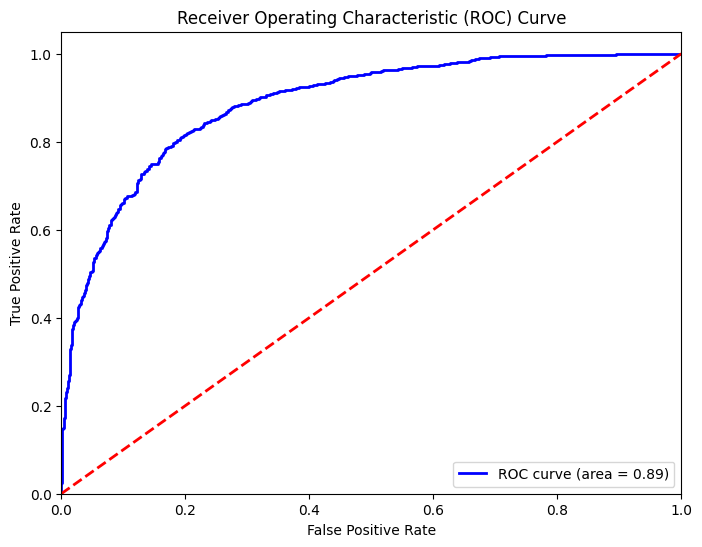

In [205]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()